In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder

from google.colab import drive
drive.mount('/content/drive/')

# Load dataset
%cd /content/drive/MyDrive/testing/
df_ccus = pd.read_csv("/content/drive/MyDrive/testing/CCUS_Clean_dataset")

Mounted at /content/drive/
/content/drive/MyDrive/testing


In [2]:
# Clean tweet text
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r"[^a-zA-Z0-9@#\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

df_ccus["clean_text"] = df_ccus["Tweet"].apply(clean_tweet)

In [3]:
# Extract hashtags and mentions
df_ccus["hashtags"] = df_ccus["Tweet"].apply(lambda x: ' '.join(re.findall(r"#\w+", str(x))))
df_ccus["mentions"] = df_ccus["Tweet"].apply(lambda x: ' '.join(re.findall(r"@\w+", str(x))))
df_ccus["full_text"] = df_ccus["clean_text"] + " " + df_ccus["hashtags"] + " " + df_ccus["mentions"]

In [4]:
# Columns to one-hot encode
sentiment_col = ["Sentiment"]
perception_cols = [
    'Perception-Fight-climate-change',
    'Perception-Climate-friendly-technology',
    'Perception-Extensive-R&D-needed',
    'Perception-Better-options-than-CCS'
]

In [5]:
# Fill NaNs and map Yes/No to 1/0
df_ccus[perception_cols] = df_ccus[perception_cols].fillna("No").replace({"Yes": 1, "No": 0})

# One-hot encode Sentiment
sentiment_encoder = OneHotEncoder(sparse_output=False)
sentiment_onehot = sentiment_encoder.fit_transform(df_ccus[sentiment_col])

# Final label matrix
Y_all = np.hstack([sentiment_onehot, df_ccus[perception_cols].values])

In [6]:
# Prepare inputs
X_text_only = df_ccus["clean_text"]
X_text_full = df_ccus["full_text"]

# Train/test split
X_text_only_train, X_text_only_test, X_text_full_train, X_text_full_test, y_train, y_test = train_test_split(
    X_text_only, X_text_full, Y_all, test_size=0.2, random_state=42
)

ValueError: Found input variables with inconsistent numbers of samples: [3030, 3030, 9090]

In [ ]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_text_only_train_vec = tfidf.fit_transform(X_text_only_train)
X_text_only_test_vec = tfidf.transform(X_text_only_test)

X_text_full_train_vec = tfidf.fit_transform(X_text_full_train)
X_text_full_test_vec = tfidf.transform(X_text_full_test)

# Build multi-output model
model_text_only = MultiOutputClassifier(LogisticRegression(max_iter=1000))
model_text_only.fit(X_text_only_train_vec, y_train)

model_text_full = MultiOutputClassifier(LogisticRegression(max_iter=1000))
model_text_full.fit(X_text_full_train_vec, y_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [ ]:
# Predict and evaluate
y_pred_text_only = model_text_only.predict(X_text_only_test_vec)
y_pred_text_full = model_text_full.predict(X_text_full_test_vec)

# Get label names
sentiment_labels = sentiment_encoder.categories_[0]
all_labels = list(sentiment_labels) + perception_cols

In [ ]:
print("\n--- Text Only Model Performance ---")
print(classification_report(y_test, y_pred_text_only, target_names=all_labels))

print("\n--- Text + Hashtags + Mentions Model Performance ---")
print(classification_report(y_test, y_pred_text_full, target_names=all_labels))


--- Text Only Model Performance ---
                                        precision    recall  f1-score   support

                              Negative       1.00      0.02      0.04        52
                               Neutral       0.84      0.99      0.91       505
                              Positive       0.00      0.00      0.00        49
       Perception-Fight-climate-change       0.00      0.00      0.00        36
Perception-Climate-friendly-technology       0.00      0.00      0.00         0
       Perception-Extensive-R&D-needed       0.00      0.00      0.00         3
    Perception-Better-options-than-CCS       0.00      0.00      0.00         6

                             micro avg       0.84      0.77      0.80       651
                             macro avg       0.26      0.14      0.14       651
                          weighted avg       0.73      0.77      0.71       651
                           samples avg       0.83      0.82      0.83       651



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [ ]:
# Compute F1 scores for both models (macro average for each label)
f1_text_only = f1_score(y_test, y_pred_text_only, average=None)
f1_text_full = f1_score(y_test, y_pred_text_full, average=None)

labels = all_labels
x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of bars

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


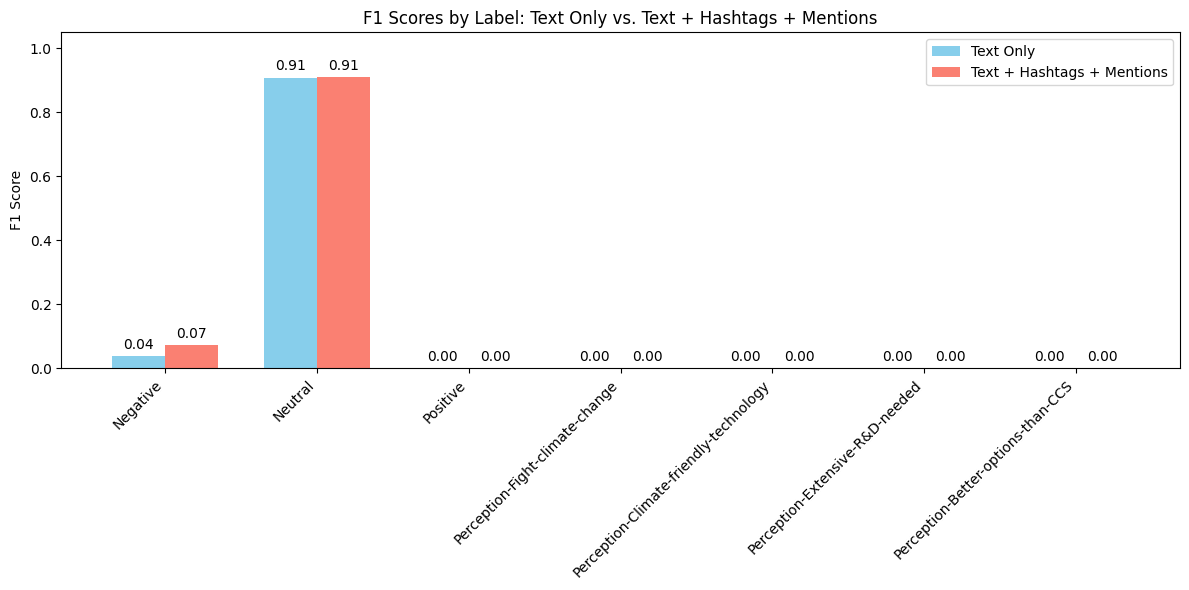

In [ ]:
x = np.arange(len(all_labels))  # one bar per label
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(12, 6))

# Bar plots
bars1 = ax.bar(x - width/2, f1_text_only, width, label='Text Only', color='skyblue')
bars2 = ax.bar(x + width/2, f1_text_full, width, label='Text + Hashtags + Mentions', color='salmon')

# Add labels to bars
ax.bar_label(bars1, fmt='%.2f', padding=3)
ax.bar_label(bars2, fmt='%.2f', padding=3)

# Axis formatting
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Label: Text Only vs. Text + Hashtags + Mentions')
ax.set_xticks(x)
ax.set_xticklabels(all_labels, rotation=45, ha='right')
ax.set_ylim(0, 1.05)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Count true label instances
print("Sentiment label counts in test set:")
print(np.sum(y_test[:, :3], axis=0))  # assuming first 3 are Sentiment one-hot

# Count predicted label instances
print("Sentiment label counts in predictions:")
print(np.sum(y_pred_text_only[:, :3], axis=0))

Sentiment label counts in test set:
[ 52. 505.  49.]
Sentiment label counts in predictions:
[  1. 598.   0.]


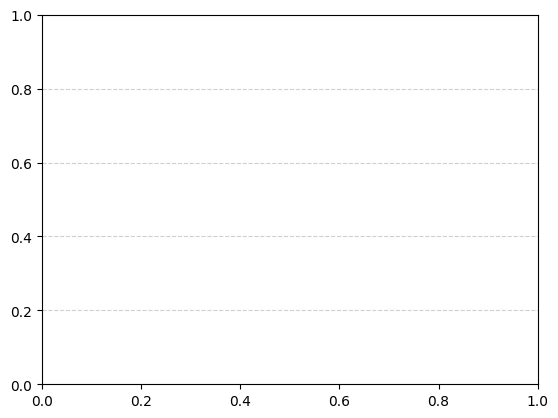

In [ ]:
# Labels & formatting
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison by Label')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Display
plt.show()
